In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error # MSE probably not ideal, but good enough for now
from sklearn.linear_model import LinearRegression,BayesianRidge,Lasso
from sklearn.model_selection import KFold

In [49]:
train = pd.read_csv('datasets/train_pca.csv')
test = pd.read_csv('datasets/test_pca.csv')
train_col = train.columns[np.logical_and.reduce([train.columns!=col for col in ['fgid','pay_adj','log_pay_adj','year']])]
test_col = test.columns[np.logical_and.reduce([test.columns!=col for col in ['fgid','pay_adj','log_pay_adj','year']])]

# remove all the ones with zero pay
train = train[train['pay_adj']>0]
test = test[test['pay_adj']>0]

train.shape, test.shape

((5077, 204), (1693, 204))

In [50]:
%%time

# make an array of zeros that will hold our mses
mses = np.zeros((2, 5))

# keep track of what split we are on
i = 0


# Make a KFold object with k=5
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 8675309)

for train_index, test_index in kfold.split(train.copy()):
    
    
    ### Training
    train_x = train.iloc[train_index].copy().fillna(0)
    train_xarr = train_x[train_col].values
    payx = train_x['log_pay_adj'].values
    
    
    ### Holdout set
    train_y = train.iloc[test_index].copy().fillna(0)
    train_yarr = train_y[train_col].values
    payy = train_y['log_pay_adj'].values
    
    ## Model 3
    model3 = LinearRegression(copy_X=True)
    model3.fit(train_xarr, payx)
    pred3 = model3.predict(train_yarr)
    mses[0,i] = mean_squared_error(payy, pred3)## record MSE
    
    ## Model 4
    model4 = BayesianRidge(copy_X=True)
    model4.fit(train_xarr, payx)
    pred4 = model4.predict(train_yarr)
    mses[1,i] = mean_squared_error(payy, pred4)

    print('fold %i complete'%i)
    ## increase i by 1
    i = i + 1

fold 0 complete
fold 1 complete
fold 2 complete
fold 3 complete
fold 4 complete
CPU times: user 3.98 s, sys: 4.11 s, total: 8.09 s
Wall time: 525 ms


In [51]:
for m,MSE in enumerate(mses.mean(axis=1)):
    print('Model %i mean MSE:'%(m+3), MSE)

Model 3 mean MSE: 35.913934464826
Model 4 mean MSE: 0.5176758198980663


In [54]:
# now let's use model 4 on the whole training and test set
full_train = train[train_col].fillna(0).values
#full_train=poly.fit_transform(full_train) # add polynomials
model3.fit(full_train, train['log_pay_adj'].values)

full_test = test[test_col].fillna(0).values
pred = model3.predict(full_test)

mean_squared_error(test['log_pay_adj'].values, pred)

7.298561748060333

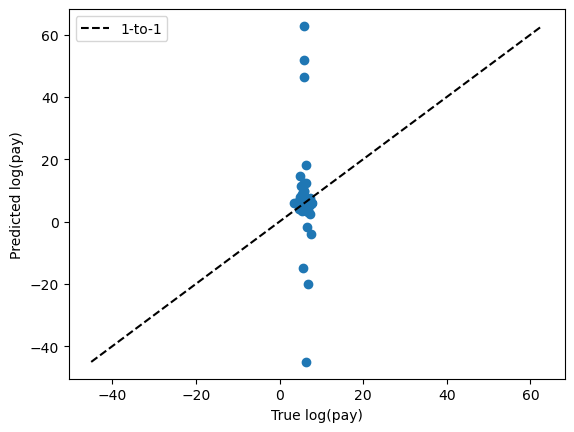

In [55]:
# while there's generally a linear correlation, it seems there is some sort of features we are missing
plt.scatter(test['log_pay_adj'].values, pred)
plt.plot([min(pred), max(pred)],[min(pred), max(pred)],'k--', label='1-to-1')
plt.xlabel('True log(pay)')
plt.ylabel('Predicted log(pay)')
plt.legend()

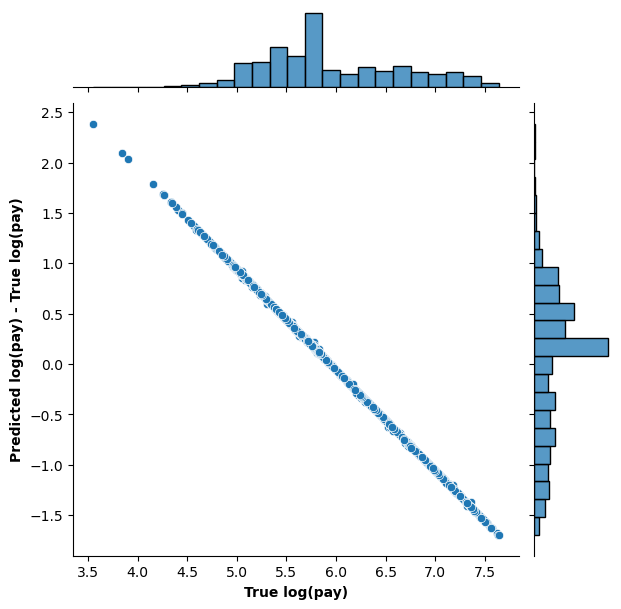

In [44]:
# plot the residuals
p = sns.jointplot(x=test['log_pay_adj'].values,y=pred-test['log_pay_adj'].values,kind='scatter')
p.ax_joint.set_xlabel('True log(pay)', fontweight='bold')
p.ax_joint.set_ylabel('Predicted log(pay) - True log(pay)', fontweight='bold')
plt.plot([min(pred),max(pred)], np.ones(2)*0, 'k--',label='zero residuals')